<a href="https://colab.research.google.com/github/DEBISMITADEY/Grad-Cam-based-brain-tumor-detection/blob/main/Brain_tumor_detection_with_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense,Dropout, Activation
from keras.layers import SimpleRNN, LSTM, Dense,GRU,Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
from scipy.stats import pearsonr
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [ ]:
import io
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/brain_tumor.zip -d /content/drive/MyDrive/Major_Project

Archive:  /content/drive/MyDrive/brain_tumor.zip
replace /content/drive/MyDrive/Major_Project/Testing/glioma_tumor/image(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# Define paths for training dataset
base_dir = '/content/drive/My Drive/Major_Project/Training'

# Define the folder paths for each class
class_folders = {
    'glioma_tumor': 0,
    'meningioma_tumor': 1,
    'no_tumor': 2,
    'pituitary_tumor': 3
}

# Initialize lists to store images and labels
train_images = []
train_labels = []

# Function to load images from class folders and assign labels
def load_training_images(base_dir, class_folders):
    for class_name, label in class_folders.items():
        folder_path = os.path.join(base_dir, class_name)
        for filename in tqdm(os.listdir(folder_path)):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is not None:
                # Resize to a consistent size, e.g., 128x128
                img = cv2.resize(img, (128, 128))
                train_images.append(img)
                train_labels.append(label)

# Load the training images
load_training_images(base_dir, class_folders)

# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

print(f"Loaded {len(train_images)} training images with labels.")


100%|██████████| 662/662 [00:16<00:00, 40.99it/s] 

Loaded 2297 training images with labels.


In [ ]:
import os
import shutil
import random

# Step 1: Define Paths
base_train_dir = '/content/drive/My Drive/Major_Project/Training'
val_dir = '/content/drive/My Drive/Major_Project/Validation'

# Step 2: Create Validation Directory
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

# Step 3: Define Validation Split Ratio
val_split_ratio = 0.2  # 20% for validation

# Step 4: Split Original Training Images
for class_name in class_folders.keys():
    class_folder_path = os.path.join(base_train_dir, class_name)
    val_class_folder = os.path.join(val_dir, class_name)

    if not os.path.exists(val_class_folder):
        os.makedirs(val_class_folder)

    all_files = os.listdir(class_folder_path)
    num_val = int(len(all_files) * val_split_ratio)
    val_files = random.sample(all_files, num_val)

    for file in val_files:
        shutil.move(os.path.join(class_folder_path, file), os.path.join(val_class_folder, file))

print("Validation set created and images moved successfully.")

# Step 5: Apply Augmentation to Remaining Training Images
# Load remaining training images and perform augmentation as previously discussed


Validation set created and images moved successfully.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the ImageDataGenerator with augmentation techniques
datagen = ImageDataGenerator(
    rotation_range=30,              # Rotate images by up to 30 degrees
    width_shift_range=0.2,          # Horizontally shift images by 20%
    height_shift_range=0.2,         # Vertically shift images by 20%
    shear_range=0.2,                # Apply shear transformations
    zoom_range=0.2,                 # Randomly zoom into images
    horizontal_flip=True,           # Randomly flip images horizontally
    fill_mode='nearest'             # Fill in missing pixels after transformation
)


In [ ]:
import os
from tqdm import tqdm

# Define the path to save augmented images
augmented_images_dir = '/content/drive/My Drive/Major_Project/augmented_images'

# Function to augment and save images
def augment_and_save_images(images, labels, class_folders, save_dir, num_augmented=5):
    for i, img in enumerate(tqdm(images)):
        img = img.reshape((1,) + img.shape)  # Reshape for the generator

        # Determine class folder based on label
        class_name = list(class_folders.keys())[list(class_folders.values()).index(labels[i])]
        img_save_dir = os.path.join(save_dir, class_name)

        if not os.path.exists(img_save_dir):
            os.makedirs(img_save_dir)

        # Generate augmented images and save
        gen = datagen.flow(img, batch_size=1, save_to_dir=img_save_dir,
                           save_prefix=f"aug_{i}", save_format='jpeg')

        for _ in range(num_augmented):
            next(gen)

# Apply augmentation and save augmented images
augment_and_save_images(train_images, train_labels, class_folders, augmented_images_dir, num_augmented=5)

print("Augmentation complete. Augmented images saved in Google Drive.")


100%|██████████| 2870/2870 [03:44<00:00, 12.81it/s]

Augmentation complete. Augmented images saved in Google Drive.


In [ ]:
import os

# Function to count images in a directory
def count_images_in_folder(base_dir):
    total_images = 0
    class_counts = {}
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
            total_images += num_images
    return total_images, class_counts

# Define the directories
training_dir = '/content/drive/My Drive/Major_Project/Training'
testing_dir = '/content/drive/My Drive/Major_Project/Testing'
augmented_images_dir = '/content/drive/My Drive/Major_Project/augmented_images'

# Count the number of images
total_training_images, training_class_counts = count_images_in_folder(training_dir)
total_testing_images, testing_class_counts = count_images_in_folder(testing_dir)
total_augmented_images, augmented_class_counts = count_images_in_folder(augmented_images_dir)

# Print the results
print("Total Training Images:", total_training_images)
print("Images per class in Training:", training_class_counts)

print("Total Testing Images:", total_testing_images)
print("Images per class in Testing:", testing_class_counts)

print("Total Augmented Images:", total_augmented_images)
print("Images per class in Augmented:", augmented_class_counts)


Total Training Images: 2297
Images per class in Training: {'glioma_tumor': 661, 'meningioma_tumor': 658, 'no_tumor': 316, 'pituitary_tumor': 662}
Total Testing Images: 394
Images per class in Testing: {'glioma_tumor': 100, 'meningioma_tumor': 115, 'no_tumor': 105, 'pituitary_tumor': 74}
Total Augmented Images: 14347
Images per class in Augmented: {'glioma_tumor': 4129, 'meningioma_tumor': 4108, 'no_tumor': 1975, 'pituitary_tumor': 4135}


In [ ]:
import os

# Define the path to the validation directory
val_dir = '/content/drive/My Drive/Major_Project/Validation'

# Initialize dictionary to hold counts for each class
val_counts = {}

# Iterate through each class folder in the validation directory
for class_name in class_folders.keys():
    class_folder_path = os.path.join(val_dir, class_name)

    # Count the number of images in the class folder
    num_images = len(os.listdir(class_folder_path))

    # Store the count for each class
    val_counts[class_name] = num_images

# Print the count for each class and the total validation images
total_val_images = sum(val_counts.values())
print(f"Validation Images per class: {val_counts}")
print(f"Total Validation Images: {total_val_images}")


Validation Images per class: {'glioma_tumor': 165, 'meningioma_tumor': 164, 'no_tumor': 79, 'pituitary_tumor': 165}
Total Validation Images: 573


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Verify validation data distribution
print(f"Validation Images per class: {val_counts}")
print(f"Total Validation Images: {total_val_images}")

# Compute class weights using training labels to handle class imbalance
class_labels = np.array(list(class_folders.values()))  # Convert to numpy array
class_weights = compute_class_weight(
    class_weight='balanced',  # Ensure classes are weighted inversely proportional to their frequency
    classes=class_labels,  # Pass the unique class labels as a numpy array
    y=train_labels  # Pass the training labels (NOT validation labels)
)

# Convert class weights into a dictionary format for model training
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print computed class weights
print("Class Weights for Imbalanced Dataset:")
for class_name, weight in zip(class_folders.keys(), class_weights):
    print(f"  {class_name}: {weight:.2f}")

# Example Output:
# Validation Images per class: {'glioma_tumor': 500, 'meningioma_tumor': 300, 'no_tumor': 100, 'pituitary_tumor': 100}
# Total Validation Images: 1000
# Class Weights for Imbalanced Dataset:
#   glioma_tumor: 0.50
#   meningioma_tumor: 0.83
#   no_tumor: 2.50
#   pituitary_tumor: 2.50


Validation Images per class: {'glioma_tumor': 165, 'meningioma_tumor': 164, 'no_tumor': 79, 'pituitary_tumor': 165}
Total Validation Images: 573
Class Weights for Imbalanced Dataset:
  glioma_tumor: 0.87
  meningioma_tumor: 0.87
  no_tumor: 1.82
  pituitary_tumor: 0.87


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG16 model without top layers (exclude the final classification layer)
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers of the VGG16 base model
for layer in base_model_vgg16.layers:
    layer.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model_vgg16.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
predictions = Dense(4, activation='softmax')(x)  # 4 output neurons for 4 classes

# Create the final model
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

# Compile the model
model_vgg16.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model_vgg16.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1024)                │         525,3

 Total params: 15,244,100 (58.15 MB)

 Trainable params: 529,412 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 275s 4s/step - accuracy: 0.4423 - loss: 1.3991 - val_accuracy: 0.6789 - val_loss: 0.8980
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 54s 688ms/step - accuracy: 0.6580 - loss: 0.8093 - val_accuracy: 0.6928 - val_loss: 0.7324
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 662ms/step - accuracy: 0.6981 - loss: 0.7155 - val_accuracy: 0.7818 - val_loss: 0.5559
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 671ms/step - accuracy: 0.7421 - loss: 0.6230 - val_accuracy: 0.8150 - val_loss: 0.4925
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 74s 582ms/step - accuracy: 0.7388 - loss: 0.6261 - val_accuracy: 0.7574 - val_loss: 0.5698
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 603ms/step - accuracy: 0.7542 - loss: 0.5949 - val_accuracy: 0.7923 - val_loss: 0.4788
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 593ms/step - accuracy: 0.7701 - loss: 0.5713 - val_accuracy: 0.8237 - val_loss: 0.5100
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 609ms/step - accuracy: 0.7583 - loss: 0.5587 - val_accuracy: 0.8063 

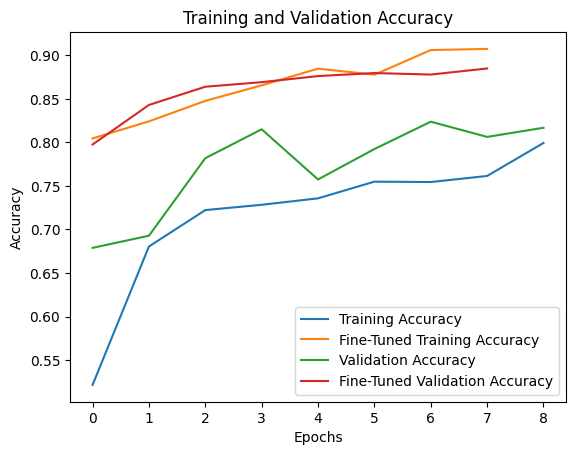

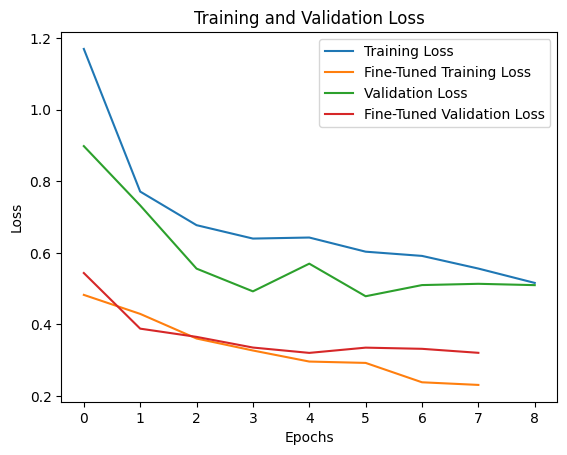

In [ ]:
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define paths to training and validation datasets
train_dir = '/content/drive/MyDrive/Major_Project/Training'  # Replace with your training dataset path
val_dir = '/content/drive/MyDrive/Major_Project/Validation'  # Replace with your validation dataset path

# Define ImageDataGenerators for data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to between 0 and 1
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation data

# Set up data generators for your dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Path to your training data
    target_size=(224, 224),  # Resize images to (224, 224) for VGG16
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,  # Path to your validation data
    target_size=(224, 224),  # Resize images to (224, 224)
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
)

# Calculate class weights
class_labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(class_labels), y=class_labels
)
class_weight_dict = dict(enumerate(class_weights))

# Load the VGG16 model with pre-trained weights and freeze the base layers
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model_vgg16.layers:
    layer.trainable = False

# Add custom layers on top of the VGG16 base model
x = Flatten()(base_model_vgg16.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
x = Dense(4, activation='softmax')(x)  # 4 classes in the output layer (adjust as needed)

# Create the final model
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=x)

# Compile the model with the correct learning rate argument
model_vgg16.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
checkpoint_vgg16 = ModelCheckpoint(
    '/content/drive/MyDrive/Major_Project/vgg16_trained_model_initial.keras',
    save_best_only=True, save_weights_only=False
)

# Train the model with initial frozen layers
history_vgg16 = model_vgg16.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight_dict,  # Using the calculated class weights
    callbacks=[early_stopping, checkpoint_vgg16],
)

# Save the trained VGG16 model after the initial training
model_vgg16.save('/content/drive/MyDrive/Major_Project/vgg16_trained_model_initial.keras')

# Fine-tuning VGG16 model - Unfreeze last few layers
for layer in base_model_vgg16.layers[-6:]:
    layer.trainable = True

# Recompile the model after unfreezing layers
model_vgg16.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Add ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-6)

# Fine-tune the model
history_vgg16_finetune = model_vgg16.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight_dict,  # Using the calculated class weights
    callbacks=[early_stopping, checkpoint_vgg16, lr_scheduler],
)

# Save the fine-tuned VGG16 model
model_vgg16.save('/content/drive/MyDrive/Major_Project/vgg16_finetuned_model.keras')

# Evaluate the fine-tuned model on the validation set
val_loss, val_accuracy = model_vgg16.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plotting training and validation accuracy
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16_finetune.history['accuracy'], label='Fine-Tuned Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_vgg16_finetune.history['val_accuracy'], label='Fine-Tuned Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16_finetune.history['loss'], label='Fine-Tuned Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.plot(history_vgg16_finetune.history['val_loss'], label='Fine-Tuned Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 88s 992ms/step - accuracy: 0.3149 - loss: 3.0619 - val_accuracy: 0.5777 - val_loss: 1.1469
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 49s 625ms/step - accuracy: 0.3579 - loss: 1.2959 - val_accuracy: 0.4607 - val_loss: 1.2001
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 74s 512ms/step - accuracy: 0.4067 - loss: 1.2743 - val_accuracy: 0.4712 - val_loss: 1.2230
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 518ms/step - accuracy: 0.3731 - loss: 1.2493 - val_accuracy: 0.4415 - val_loss: 1.2306
Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 72s 691ms/step - accuracy: 0.3322 - loss: 1.8104 - val_accuracy: 0.3944 - val_loss: 1.1501 - learning_rate: 1.0000e-05
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 81s 828ms/step - accuracy: 0.4233 - loss: 1.1808 - val_accuracy: 0.4590 - val_loss: 1.1402 - learning_rate: 1.0000e-05
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 65s 858ms/step - accuracy: 0.4806 - loss: 1.1494 - val_accuracy: 0.4764 - val_loss: 1.1343 - learning_rate: 1.0000e-05
Epoch 4/10
72/72 ━━━━━━━

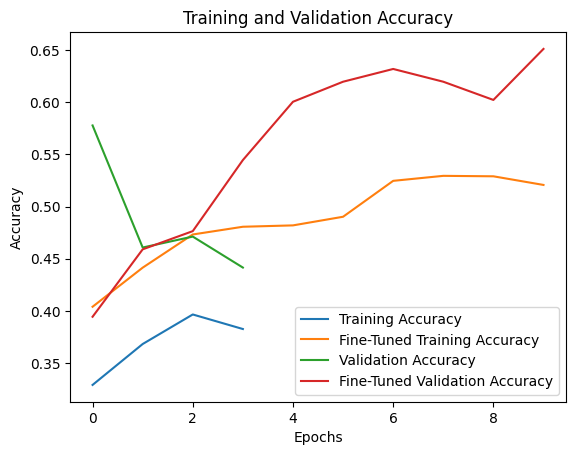

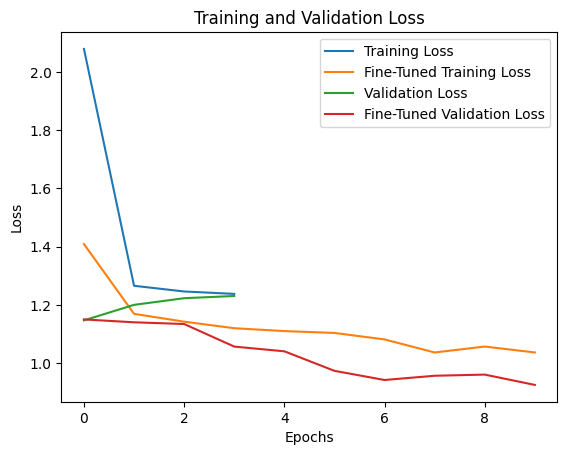

In [ ]:
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define paths to training and validation datasets
train_dir = '/content/drive/MyDrive/Major_Project/Training'  # Replace with your training dataset path
val_dir = '/content/drive/MyDrive/Major_Project/Validation'  # Replace with your validation dataset path

# Define ImageDataGenerators for data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to between 0 and 1
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation data

# Set up data generators for your dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Path to your training data
    target_size=(224, 224),  # Resize images to (224, 224) for ResNet50
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,  # Path to your validation data
    target_size=(224, 224),  # Resize images to (224, 224)
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
)

# Calculate class weights
class_labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(class_labels), y=class_labels
)
class_weight_dict = dict(enumerate(class_weights))

# Load the ResNet50 model with pre-trained weights and freeze the base layers
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model_resnet.layers:
    layer.trainable = False

# Add custom layers on top of the ResNet50 base model
x = Flatten()(base_model_resnet.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
x = Dense(4, activation='softmax')(x)  # 4 classes in the output layer (adjust as needed)

# Create the final model
model_resnet = Model(inputs=base_model_resnet.input, outputs=x)

# Compile the model with the correct learning rate argument
model_resnet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
checkpoint_resnet = ModelCheckpoint(
    '/content/drive/MyDrive/Major_Project/resnet_trained_model_initial.keras',
    save_best_only=True, save_weights_only=False
)

# Train the model with initial frozen layers
history_resnet = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight_dict,  # Using the calculated class weights
    callbacks=[early_stopping, checkpoint_resnet],
)

# Save the trained ResNet50 model after the initial training
model_resnet.save('/content/drive/MyDrive/Major_Project/resnet_trained_model_initial.keras')

# Fine-tuning ResNet50 model - Unfreeze last few layers
for layer in base_model_resnet.layers[-6:]:
    layer.trainable = True

# Recompile the model after unfreezing layers
model_resnet.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Add ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-6)

# Fine-tune the model
history_resnet_finetune = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight_dict,  # Using the calculated class weights
    callbacks=[early_stopping, checkpoint_resnet, lr_scheduler],
)

# Save the fine-tuned ResNet50 model
model_resnet.save('/content/drive/MyDrive/Major_Project/resnet_finetuned_model.keras')

# Evaluate the fine-tuned model on the validation set
val_loss, val_accuracy = model_resnet.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plotting training and validation accuracy
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet_finetune.history['accuracy'], label='Fine-Tuned Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_resnet_finetune.history['val_accuracy'], label='Fine-Tuned Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet_finetune.history['loss'], label='Fine-Tuned Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.plot(history_resnet_finetune.history['val_loss'], label='Fine-Tuned Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.4896 - loss: 3.4177 - val_accuracy: 0.7958 - val_loss: 0.5226
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 80s 539ms/step - accuracy: 0.7523 - loss: 0.6566 - val_accuracy: 0.8115 - val_loss: 0.5687
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 90s 644ms/step - accuracy: 0.7695 - loss: 0.5744 - val_accuracy: 0.7976 - val_loss: 0.4900
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 656ms/step - accuracy: 0.7922 - loss: 0.4946 - val_accuracy: 0.8028 - val_loss: 0.5123
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 80s 620ms/step - accuracy: 0.7965 - loss: 0.5005 - val_accuracy: 0.8150 - val_loss: 0.4474
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 51s 664ms/step - accuracy: 0.8258 - loss: 0.4457 - val_accuracy: 0.8412 - val_loss: 0.4365
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 90s 786ms/step - accuracy: 0.8310 - loss: 0.4173 - val_accuracy: 0.8517 - val_loss: 0.3730
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 615ms/step - accuracy: 0.8144 - loss: 0.4476 - val_accuracy: 0.8639 

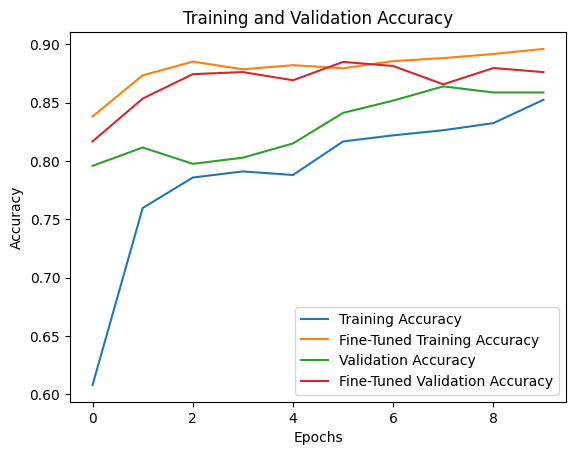

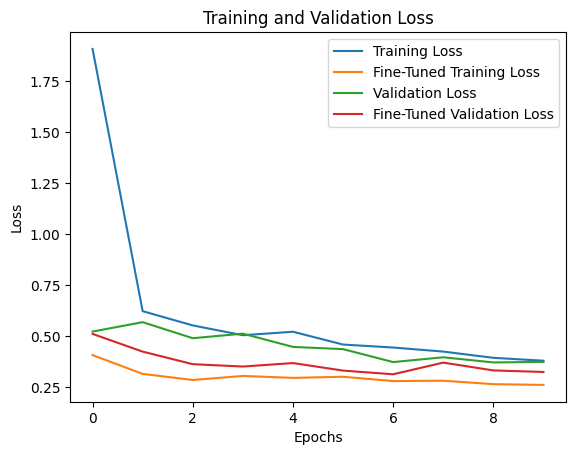

In [ ]:
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121  # Using DenseNet121 as base model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define paths to training and validation datasets
train_dir = '/content/drive/MyDrive/Major_Project/Training'  # Replace with your training dataset path
val_dir = '/content/drive/MyDrive/Major_Project/Validation'  # Replace with your validation dataset path

# Define ImageDataGenerators for data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to between 0 and 1
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation data

# Set up data generators for your dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Path to your training data
    target_size=(224, 224),  # Resize images to (224, 224) for DenseNet
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,  # Path to your validation data
    target_size=(224, 224),  # Resize images to (224, 224)
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
)

# Calculate class weights
class_labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(class_labels), y=class_labels
)
class_weight_dict = dict(enumerate(class_weights))

# Load the DenseNet model with pre-trained weights and freeze the base layers
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model_densenet.layers:
    layer.trainable = False

# Add custom layers on top of the DenseNet base model
x = Flatten()(base_model_densenet.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
x = Dense(4, activation='softmax')(x)  # 4 classes in the output layer (adjust as needed)

# Create the final model
model_densenet = Model(inputs=base_model_densenet.input, outputs=x)

# Compile the model with the correct learning rate argument
model_densenet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
checkpoint_densenet = ModelCheckpoint(
    '/content/drive/MyDrive/Major_Project/densenet_trained_model_initial.keras',
    save_best_only=True, save_weights_only=False
)

# Train the model with initial frozen layers
history_densenet = model_densenet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight_dict,  # Using the calculated class weights
    callbacks=[early_stopping, checkpoint_densenet],
)

# Save the trained DenseNet model after the initial training
model_densenet.save('/content/drive/MyDrive/Major_Project/densenet_trained_model_initial.keras')

# Fine-tuning DenseNet model - Unfreeze last few layers
for layer in base_model_densenet.layers[-6:]:
    layer.trainable = True

# Recompile the model after unfreezing layers
model_densenet.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Add ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-6)

# Fine-tune the model
history_densenet_finetune = model_densenet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight_dict,  # Using the calculated class weights
    callbacks=[early_stopping, checkpoint_densenet, lr_scheduler],
)

# Save the fine-tuned DenseNet model
model_densenet.save('/content/drive/MyDrive/Major_Project/densenet_finetuned_model.keras')

# Evaluate the fine-tuned model on the validation set
val_loss, val_accuracy = model_densenet.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plotting training and validation accuracy
plt.plot(history_densenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_densenet_finetune.history['accuracy'], label='Fine-Tuned Training Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_densenet_finetune.history['val_accuracy'], label='Fine-Tuned Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history_densenet.history['loss'], label='Training Loss')
plt.plot(history_densenet_finetune.history['loss'], label='Fine-Tuned Training Loss')
plt.plot(history_densenet.history['val_loss'], label='Validation Loss')
plt.plot(history_densenet_finetune.history['val_loss'], label='Fine-Tuned Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 314s 4s/step - accuracy: 0.4339 - loss: 3.9203 - val_accuracy: 0.7644 - val_loss: 0.6027
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 46s 585ms/step - accuracy: 0.7147 - loss: 0.7244 - val_accuracy: 0.7679 - val_loss: 0.6138
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 610ms/step - accuracy: 0.7216 - loss: 0.7234 - val_accuracy: 0.8168 - val_loss: 0.4869
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 637ms/step - accuracy: 0.7281 - loss: 0.6438 - val_accuracy: 0.8342 - val_loss: 0.4671
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 569ms/step - accuracy: 0.7743 - loss: 0.5484 - val_accuracy: 0.7923 - val_loss: 0.5048
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 49s 613ms/step - accuracy: 0.7582 - loss: 0.5700 - val_accuracy: 0.8185 - val_loss: 0.4313
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 74s 506ms/step - accuracy: 0.7786 - loss: 0.5266 - val_accuracy: 0.8237 - val_loss: 0.4324
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 514ms/step - accuracy: 0.7783 - loss: 0.5564 - val_accuracy: 0.7766 

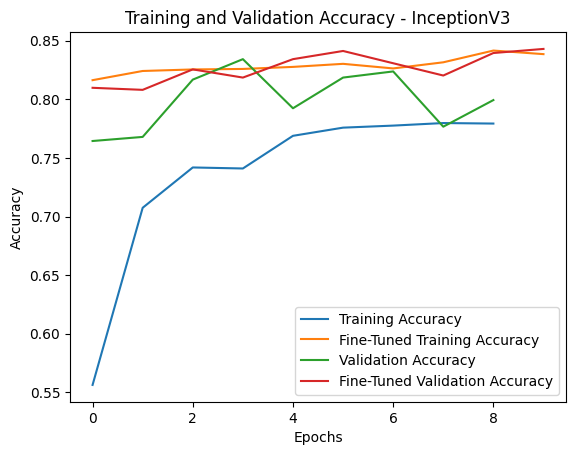

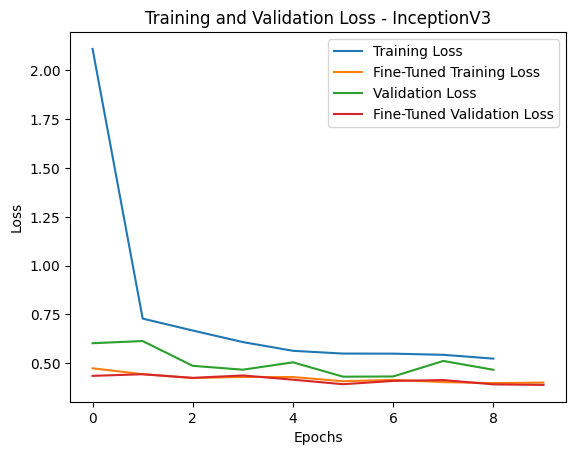

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to training and validation datasets
train_dir = '/content/drive/MyDrive/Major_Project/Training'  # Replace with your path
val_dir = '/content/drive/MyDrive/Major_Project/Validation'  # Replace with your path

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Calculate class weights
class_labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(class_labels), y=class_labels
)
class_weight_dict = dict(enumerate(class_weights))

# Load InceptionV3 model with pre-trained weights and freeze base layers
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_inception.layers:
    layer.trainable = False

# Add custom layers
x = Flatten()(base_model_inception.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation='softmax')(x)  # 4 classes (adjust as needed)

# Create the final model
model_inception = Model(inputs=base_model_inception.input, outputs=output_layer)

# Compile the model
model_inception.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_inception = ModelCheckpoint(
    '/content/drive/MyDrive/Major_Project/inception_trained_model_initial.keras',
    save_best_only=True, save_weights_only=False
)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-6)

# Train the model with frozen layers
history_inception = model_inception.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, checkpoint_inception]
)

# Save the trained model
model_inception.save('/content/drive/MyDrive/Major_Project/inception_trained_model_initial.keras')

# Fine-tune the model - Unfreeze some layers
for layer in base_model_inception.layers[-6:]:
    layer.trainable = True

# Recompile the model after unfreezing layers
model_inception.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_inception_finetune = model_inception.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, checkpoint_inception, lr_scheduler]
)

# Save the fine-tuned model
model_inception.save('/content/drive/MyDrive/Major_Project/inception_finetuned_model.keras')

# Evaluate the model
val_loss, val_accuracy = model_inception.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plotting training and validation accuracy
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception_finetune.history['accuracy'], label='Fine-Tuned Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_inception_finetune.history['val_accuracy'], label='Fine-Tuned Validation Accuracy')
plt.title('Training and Validation Accuracy - InceptionV3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history_inception.history['loss'], label='Training Loss')
plt.plot(history_inception_finetune.history['loss'], label='Fine-Tuned Training Loss')
plt.plot(history_inception.history['val_loss'], label='Validation Loss')
plt.plot(history_inception_finetune.history['val_loss'], label='Fine-Tuned Validation Loss')
plt.title('Training and Validation Loss - InceptionV3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import os

normal_trained_model_path = "/content/drive/MyDrive/Major_Project/densenet_trained_model_initial.keras"
print("File exists:", os.path.exists(normal_trained_model_path))


File exists: True


Found 573 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 963ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 556ms/step


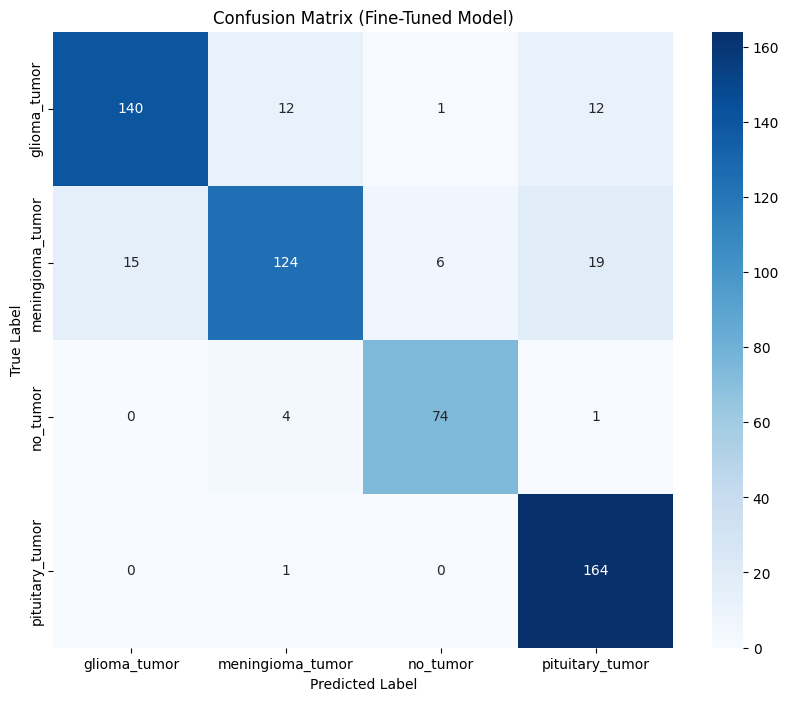

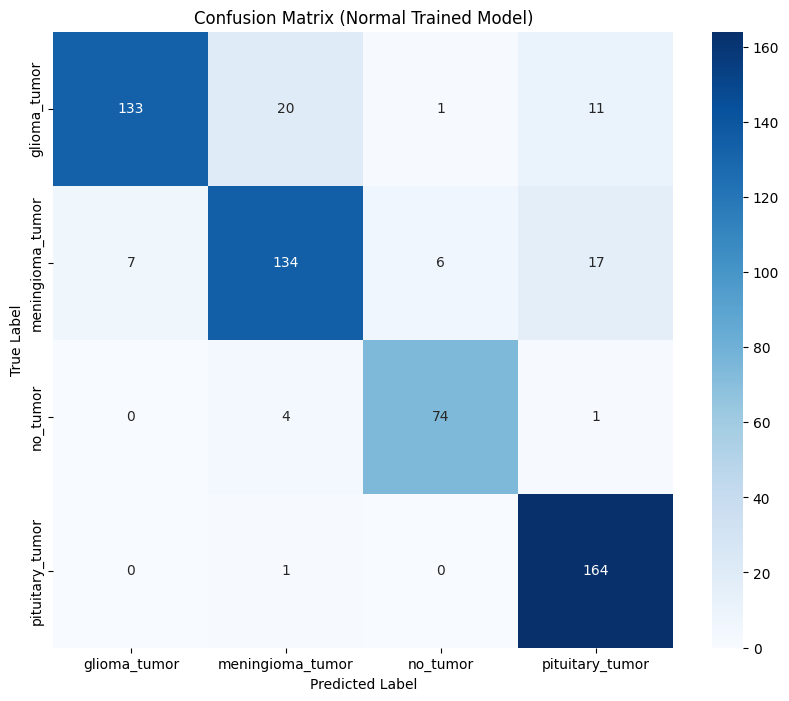

Fine-Tuned Model Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.85      0.88       165
meningioma_tumor       0.88      0.76      0.81       164
        no_tumor       0.91      0.94      0.93        79
 pituitary_tumor       0.84      0.99      0.91       165

        accuracy                           0.88       573
       macro avg       0.88      0.88      0.88       573
    weighted avg       0.88      0.88      0.87       573

Normal Trained Model Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.81      0.87       165
meningioma_tumor       0.84      0.82      0.83       164
        no_tumor       0.91      0.94      0.93        79
 pituitary_tumor       0.85      0.99      0.92       165

        accuracy                           0.88       573
       macro avg       0.89      0.89      0.89       573
    weighted avg       0.89      0.88    

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Download models from Drive
# After downloading, specify the file paths to the saved models
fine_tuned_model_path = "/content/drive/MyDrive/Major_Project/densenet_finetuned_model.keras"
normal_trained_model_path = "/content/drive/MyDrive/Major_Project/densenet_trained_model_initial.keras"

# Load the models
fine_tuned_model = load_model(fine_tuned_model_path)
normal_trained_model = load_model(normal_trained_model_path)

# Step 2: Prepare test/validation data generator
val_dir = '/content/drive/MyDrive/Major_Project/Validation'  # Path to your validation dataset

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # Resize images to match input shape
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    shuffle=False  # Do not shuffle to maintain order for confusion matrix
)

# Step 3: Predict on validation data
val_labels = val_generator.classes  # True labels
val_class_indices = val_generator.class_indices  # Map class labels to indices
class_names = list(val_class_indices.keys())  # Get class names

# Predict using fine-tuned model
fine_tuned_predictions = fine_tuned_model.predict(val_generator)
fine_tuned_pred_classes = np.argmax(fine_tuned_predictions, axis=1)

# Predict using normal-trained model
normal_predictions = normal_trained_model.predict(val_generator)
normal_pred_classes = np.argmax(normal_predictions, axis=1)

# Step 4: Generate confusion matrices
# Fine-tuned model confusion matrix
fine_tuned_cm = confusion_matrix(val_labels, fine_tuned_pred_classes)

# Normal-trained model confusion matrix
normal_cm = confusion_matrix(val_labels, normal_pred_classes)

# Plot confusion matrices
def plot_confusion_matrix(cm, title, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(fine_tuned_cm, "Confusion Matrix (Fine-Tuned Model)", class_names)
plot_confusion_matrix(normal_cm, "Confusion Matrix (Normal Trained Model)", class_names)

# Optional: Print classification reports
print("Fine-Tuned Model Classification Report:")
print(classification_report(val_labels, fine_tuned_pred_classes, target_names=class_names))

print("Normal Trained Model Classification Report:")
print(classification_report(val_labels, normal_pred_classes, target_names=class_names))


Found 573 images belonging to 4 classes.
Generating predictions for the Fine-Tuned VGG16 model...


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 917ms/step
Generating predictions for the Normal-Trained VGG16 model...
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step
Fine-Tuned Model Accuracy: 0.88
Normal-Trained Model Accuracy: 0.88

--- Confusion Matrices ---



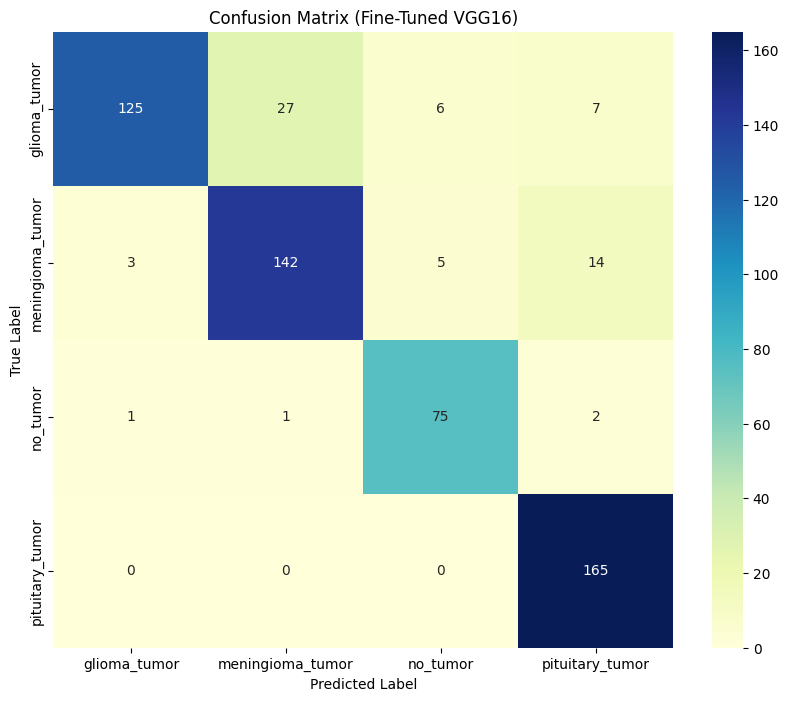

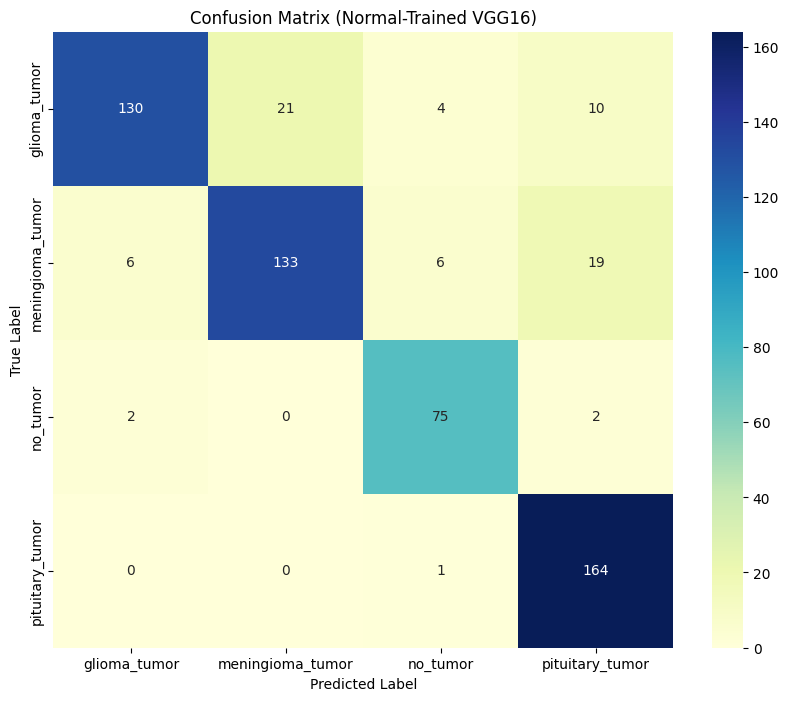


--- Classification Reports ---

Fine-Tuned VGG16 Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.76      0.85       165
meningioma_tumor       0.84      0.87      0.85       164
        no_tumor       0.87      0.95      0.91        79
 pituitary_tumor       0.88      1.00      0.93       165

        accuracy                           0.88       573
       macro avg       0.89      0.89      0.89       573
    weighted avg       0.89      0.88      0.88       573


Normal-Trained VGG16 Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.79      0.86       165
meningioma_tumor       0.86      0.81      0.84       164
        no_tumor       0.87      0.95      0.91        79
 pituitary_tumor       0.84      0.99      0.91       165

        accuracy                           0.88       573
       macro avg       0.88      0.89      0.88       573
    wei

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Specify file paths for VGG16 models
fine_tuned_vgg16_path = "/content/drive/MyDrive/Major_Project/vgg16_finetuned_model.keras"
normal_trained_vgg16_path = "/content/drive/MyDrive/Major_Project/vgg16_trained_model_initial.keras"

# Load the VGG16 models
fine_tuned_vgg16 = load_model(fine_tuned_vgg16_path)
normal_trained_vgg16 = load_model(normal_trained_vgg16_path)

# Step 2: Prepare the validation data generator
val_dir = '/content/drive/MyDrive/Major_Project/Validation'  # Path to validation dataset
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # Adjust to VGG16 input size
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Keep the order consistent for confusion matrix
)

# Step 3: Get true labels and class names
val_labels = val_generator.classes  # True class labels
val_class_indices = val_generator.class_indices  # Mapping of class names to indices
class_names = list(val_class_indices.keys())  # Get class names

# Step 4: Predict with VGG16 models
# Fine-tuned model predictions
print("Generating predictions for the Fine-Tuned VGG16 model...")
fine_tuned_predictions = fine_tuned_vgg16.predict(val_generator, verbose=1)
fine_tuned_pred_classes = np.argmax(fine_tuned_predictions, axis=1)

# Normal-trained model predictions
print("Generating predictions for the Normal-Trained VGG16 model...")
normal_predictions = normal_trained_vgg16.predict(val_generator, verbose=1)
normal_pred_classes = np.argmax(normal_predictions, axis=1)

# Step 5: Generate confusion matrices and classification reports
# Fine-Tuned Model Evaluation
fine_tuned_cm = confusion_matrix(val_labels, fine_tuned_pred_classes)
fine_tuned_accuracy = accuracy_score(val_labels, fine_tuned_pred_classes)
print(f"Fine-Tuned Model Accuracy: {fine_tuned_accuracy:.2f}")

# Normal-Trained Model Evaluation
normal_cm = confusion_matrix(val_labels, normal_pred_classes)
normal_accuracy = accuracy_score(val_labels, normal_pred_classes)
print(f"Normal-Trained Model Accuracy: {normal_accuracy:.2f}")

# Step 6: Plot confusion matrices
def plot_confusion_matrix(cm, title, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

print("\n--- Confusion Matrices ---\n")
plot_confusion_matrix(fine_tuned_cm, "Confusion Matrix (Fine-Tuned VGG16)", class_names)
plot_confusion_matrix(normal_cm, "Confusion Matrix (Normal-Trained VGG16)", class_names)

# Step 7: Display classification reports
print("\n--- Classification Reports ---\n")
print("Fine-Tuned VGG16 Classification Report:")
print(classification_report(val_labels, fine_tuned_pred_classes, target_names=class_names))

print("\nNormal-Trained VGG16 Classification Report:")
print(classification_report(val_labels, normal_pred_classes, target_names=class_names))


Found 573 images belonging to 4 classes.
Generating predictions for the Fine-Tuned Inception model...


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 488ms/step
Generating predictions for the Normal-Trained Inception model...
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 450ms/step
Fine-Tuned Model Accuracy: 0.84
Normal-Trained Model Accuracy: 0.84

--- Confusion Matrices ---



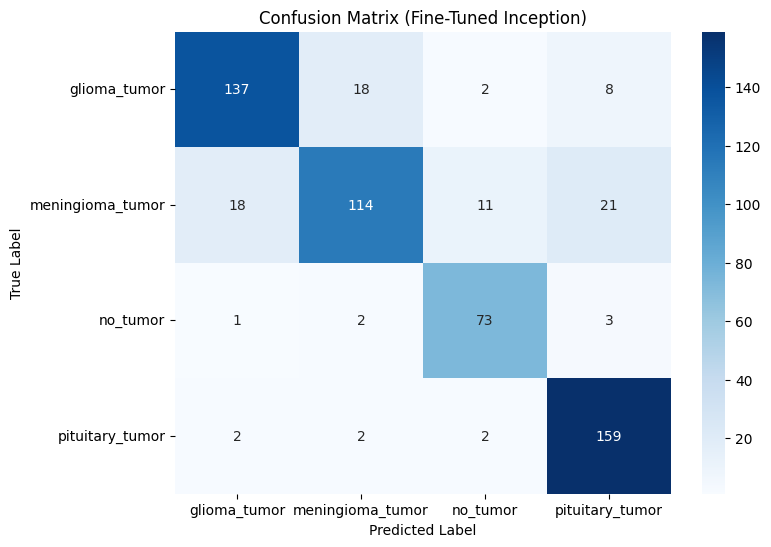

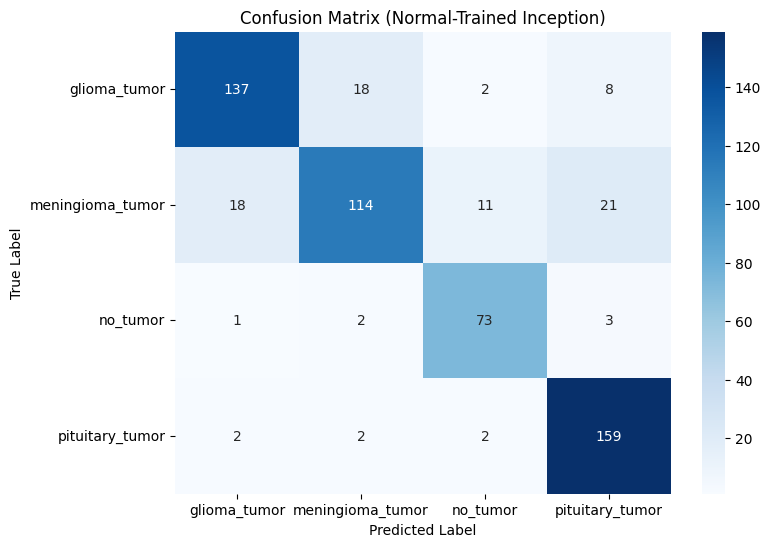


--- Classification Reports ---

Fine-Tuned Inception Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.87      0.83      0.85       165
meningioma_tumor       0.84      0.70      0.76       164
        no_tumor       0.83      0.92      0.87        79
 pituitary_tumor       0.83      0.96      0.89       165

        accuracy                           0.84       573
       macro avg       0.84      0.85      0.84       573
    weighted avg       0.84      0.84      0.84       573


Normal-Trained Inception Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.87      0.83      0.85       165
meningioma_tumor       0.84      0.70      0.76       164
        no_tumor       0.83      0.92      0.87        79
 pituitary_tumor       0.83      0.96      0.89       165

        accuracy                           0.84       573
       macro avg       0.84      0.85      0.84       573

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Specify file paths for Inception models
fine_tuned_inception_path = "/content/drive/MyDrive/Major_Project/inception_finetuned_model.keras"
normal_trained_inception_path = "/content/drive/MyDrive/Major_Project/inception_trained_model_initial.keras"

# Load the Inception models
fine_tuned_inception = load_model(fine_tuned_inception_path)
normal_trained_inception = load_model(normal_trained_inception_path)

# Step 2: Prepare the validation data generator
val_dir = '/content/drive/MyDrive/Major_Project/Validation'  # Path to validation dataset
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # Adjust to Inception input size
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Keep the order consistent for confusion matrix
)

# Step 3: Get true labels and class names
val_labels = val_generator.classes  # True class labels
val_class_indices = val_generator.class_indices  # Mapping of class names to indices
class_names = list(val_class_indices.keys())  # Get class names

# Step 4: Predict with Inception models
# Fine-tuned model predictions
print("Generating predictions for the Fine-Tuned Inception model...")
fine_tuned_predictions = fine_tuned_inception.predict(val_generator, verbose=1)
fine_tuned_pred_classes = np.argmax(fine_tuned_predictions, axis=1)

# Normal-trained model predictions
print("Generating predictions for the Normal-Trained Inception model...")
normal_predictions = normal_trained_inception.predict(val_generator, verbose=1)
normal_pred_classes = np.argmax(normal_predictions, axis=1)

# Step 5: Generate confusion matrices and classification reports
# Fine-Tuned Model Evaluation
fine_tuned_cm = confusion_matrix(val_labels, fine_tuned_pred_classes)
fine_tuned_accuracy = accuracy_score(val_labels, fine_tuned_pred_classes)
print(f"Fine-Tuned Model Accuracy: {fine_tuned_accuracy:.2f}")

# Normal-Trained Model Evaluation
normal_cm = confusion_matrix(val_labels, normal_pred_classes)
normal_accuracy = accuracy_score(val_labels, normal_pred_classes)
print(f"Normal-Trained Model Accuracy: {normal_accuracy:.2f}")

# Step 6: Plot confusion matrices
def plot_confusion_matrix(cm, title, class_names, size=(8, 6)):
    plt.figure(figsize=size)  # Smaller matrix plot size
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

print("\n--- Confusion Matrices ---\n")
plot_confusion_matrix(fine_tuned_cm, "Confusion Matrix (Fine-Tuned Inception)", class_names, size=(8, 6))
plot_confusion_matrix(normal_cm, "Confusion Matrix (Normal-Trained Inception)", class_names, size=(8, 6))

# Step 7: Display classification reports
print("\n--- Classification Reports ---\n")
print("Fine-Tuned Inception Classification Report:")
print(classification_report(val_labels, fine_tuned_pred_classes, target_names=class_names))

print("\nNormal-Trained Inception Classification Report:")
print(classification_report(val_labels, normal_pred_classes, target_names=class_names))


Found 573 images belonging to 4 classes.
Generating predictions for the Fine-Tuned ResNet model...


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 494ms/step
Generating predictions for the Normal-Trained ResNet model...
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 364ms/step
Fine-Tuned Model Accuracy: 0.65
Normal-Trained Model Accuracy: 0.65

--- Confusion Matrices ---



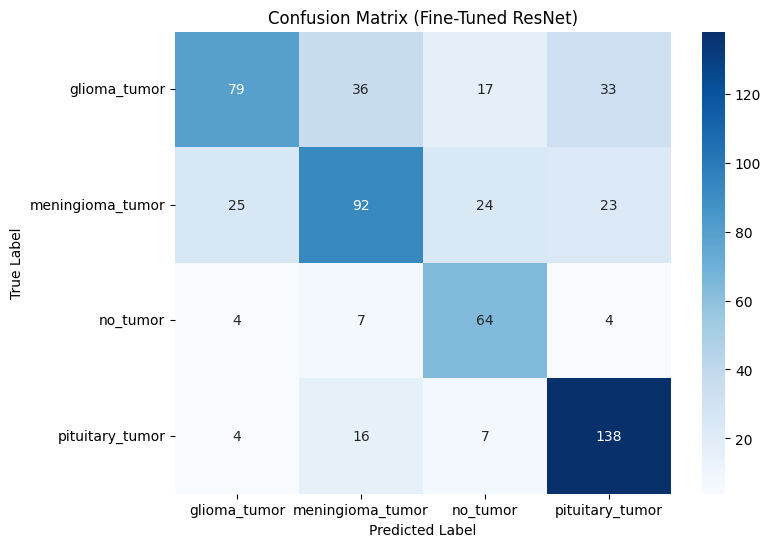

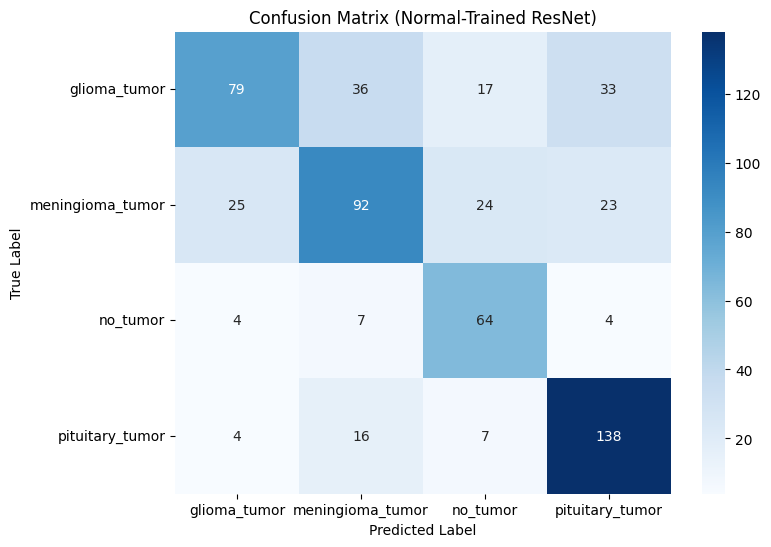


--- Classification Reports ---

Fine-Tuned ResNet Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.71      0.48      0.57       165
meningioma_tumor       0.61      0.56      0.58       164
        no_tumor       0.57      0.81      0.67        79
 pituitary_tumor       0.70      0.84      0.76       165

        accuracy                           0.65       573
       macro avg       0.65      0.67      0.65       573
    weighted avg       0.66      0.65      0.64       573


Normal-Trained ResNet Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.71      0.48      0.57       165
meningioma_tumor       0.61      0.56      0.58       164
        no_tumor       0.57      0.81      0.67        79
 pituitary_tumor       0.70      0.84      0.76       165

        accuracy                           0.65       573
       macro avg       0.65      0.67      0.65       573
    w

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Specify file paths for ResNet models
fine_tuned_resnet_path = "/content/drive/MyDrive/Major_Project/resnet_finetuned_model.keras"
normal_trained_resnet_path = "/content/drive/MyDrive/Major_Project/resnet_trained_model_initial.keras"

# Load the ResNet models
fine_tuned_resnet = load_model(fine_tuned_resnet_path)
normal_trained_resnet = load_model(normal_trained_resnet_path)

# Step 2: Prepare the validation data generator
val_dir = '/content/drive/MyDrive/Major_Project/Validation'  # Path to validation dataset
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # Adjust to ResNet input size
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Keep the order consistent for confusion matrix
)

# Step 3: Get true labels and class names
val_labels = val_generator.classes  # True class labels
val_class_indices = val_generator.class_indices  # Mapping of class names to indices
class_names = list(val_class_indices.keys())  # Get class names

# Step 4: Predict with ResNet models
# Fine-tuned model predictions
print("Generating predictions for the Fine-Tuned ResNet model...")
fine_tuned_predictions = fine_tuned_resnet.predict(val_generator, verbose=1)
fine_tuned_pred_classes = np.argmax(fine_tuned_predictions, axis=1)

# Normal-trained model predictions
print("Generating predictions for the Normal-Trained ResNet model...")
normal_predictions = normal_trained_resnet.predict(val_generator, verbose=1)
normal_pred_classes = np.argmax(normal_predictions, axis=1)

# Step 5: Generate confusion matrices and classification reports
# Fine-Tuned Model Evaluation
fine_tuned_cm = confusion_matrix(val_labels, fine_tuned_pred_classes)
fine_tuned_accuracy = accuracy_score(val_labels, fine_tuned_pred_classes)
print(f"Fine-Tuned Model Accuracy: {fine_tuned_accuracy:.2f}")

# Normal-Trained Model Evaluation
normal_cm = confusion_matrix(val_labels, normal_pred_classes)
normal_accuracy = accuracy_score(val_labels, normal_pred_classes)
print(f"Normal-Trained Model Accuracy: {normal_accuracy:.2f}")

# Step 6: Plot confusion matrices
def plot_confusion_matrix(cm, title, class_names, size=(8, 6)):
    plt.figure(figsize=size)  # Smaller matrix plot size
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

print("\n--- Confusion Matrices ---\n")
plot_confusion_matrix(fine_tuned_cm, "Confusion Matrix (Fine-Tuned ResNet)", class_names, size=(8, 6))
plot_confusion_matrix(normal_cm, "Confusion Matrix (Normal-Trained ResNet)", class_names, size=(8, 6))

# Step 7: Display classification reports
print("\n--- Classification Reports ---\n")
print("Fine-Tuned ResNet Classification Report:")
print(classification_report(val_labels, fine_tuned_pred_classes, target_names=class_names))

print("\nNormal-Trained ResNet Classification Report:")
print(classification_report(val_labels, normal_pred_classes, target_names=class_names))


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Load the VGG16 model (use the correct path to your saved model)
vgg_model_path = '/content/drive/MyDrive/Major_Project/vgg16_finetuned_model.keras'  # Replace with your actual path
model = load_model(vgg_model_path)

# Function to preprocess the input image for VGG16 model
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image to 224x224
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return preprocess_input(img_array)  # Preprocess for VGG16

# Function to apply Grad-CAM
def grad_cam(input_model, img_path, layer_name="block5_conv3"):
    # Preprocess the image
    processed_image = preprocess_image(img_path)

    # Use tf.GradientTape to calculate gradients
    with tf.GradientTape() as tape:
        # Watch the input image for computing the gradient
        tape.watch(input_model.input)
        # Get the output of the specified layer
        conv_output = input_model.get_layer(layer_name).output
        # Make predictions
        predictions = input_model(processed_image)

    # Get the predicted class
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Get the gradient of the class score with respect to the convolutional output
    grads = tape.gradient(predictions[:, predicted_class], conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Pool the gradients over all axes except channels

    # Get the conv layer output
    conv_output = conv_output[0]

    # Multiply the convolution output with the pooled gradients
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    # Average the weighted activation values across all channels
    heatmap = np.mean(conv_output, axis=-1)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)  # ReLU activation to focus on positive gradients
    heatmap /= np.max(heatmap)  # Normalize

    # Convert the heatmap to an image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Resize to input image size
    heatmap = np.uint8(255 * heatmap)  # Convert to 0-255 range
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)  # Superimpose the heatmap on the image

    return superimposed_img

# Provide the path to the image you want to visualize Grad-CAM for
img_path = '/content/drive/MyDrive/Major_Project/image(1).jpg'  # Replace with the correct image path

# Apply Grad-CAM and visualize
grad_cam_img = grad_cam(model, img_path)

# Display the image with Grad-CAM
plt.imshow(grad_cam_img)
plt.axis('off')  # Turn off axis
plt.show()



ValueError: Passed in object <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=input_layer_5> of type 'KerasTensor', not tf.Tensor or tf.Variable or ExtensionType.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the VGG16 model (use the correct path to your saved model)
vgg_model_path = '/content/drive/MyDrive/Major_Project/vgg16_finetuned_model.keras'  # Replace with your actual path
model = load_model(vgg_model_path)

# Function to preprocess the input image for VGG16 model
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image to 224x224
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return preprocess_input(img_array)  # Preprocess for VGG16

# Function to apply Grad-CAM
def grad_cam(input_model, img_path, layer_name="block5_conv3"):
    # Preprocess the image
    processed_image = preprocess_image(img_path)

    # Use tf.GradientTape to calculate gradients
    with tf.GradientTape() as tape:
        # Watch the input image for computing the gradient
        tape.watch(processed_image)

        # Get the model's prediction
        preds = input_model(processed_image, training=False)

        # Get the output of the specified convolutional layer (use an intermediate model)
        conv_layer_model = tf.keras.Model(inputs=input_model.input, outputs=input_model.get_layer(layer_name).output)
        conv_output = conv_layer_model(processed_image)

    # Get the predicted class index (the index of max prediction)
    predicted_class = np.argmax(preds, axis=-1)[0]

    # Get the gradient of the predicted class score with respect to the convolutional output
    grads = tape.gradient(preds[:, predicted_class], conv_output)

    # Pool the gradients over all axes except the channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get the conv layer output (activations)
    conv_output = conv_output[0]

    # Multiply the convolution output with the pooled gradients
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    # Average the weighted activation values across all channels
    heatmap = np.mean(conv_output, axis=-1)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)  # ReLU activation to focus on positive gradients
    heatmap /= np.max(heatmap)  # Normalize

    # Convert the heatmap to an image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize to match input size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Resize heatmap to match input image size
    heatmap = np.uint8(255 * heatmap)  # Convert to 0-255 range
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap to the heatmap
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)  # Superimpose the heatmap on the image

    return superimposed_img

# Provide the path to the image you want to visualize Grad-CAM for
img_path = '/content/drive/MyDrive/Major_Project/image(1).jpg'  # Replace with your correct image path

# Apply Grad-CAM and visualize
grad_cam_img = grad_cam(model, img_path)

# Display the image with Grad-CAM
plt.imshow(grad_cam_img)
plt.axis('off')  # Turn off axis
plt.show()


ValueError: Passed in object [[[[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  ...

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]

  [[-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   ...
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]
   [-103.939 -116.779 -123.68 ]]]] of type 'ndarray', not tf.Tensor or tf.Variable or ExtensionType.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the VGG16 model (use the correct path to your saved model)
vgg_model_path = '/content/drive/MyDrive/Major_Project/vgg16_finetuned_model.keras'  # Replace with your actual path
model = load_model(vgg_model_path)

# Function to preprocess the input image for VGG16 model
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image to 224x224
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess for VGG16
    return tf.convert_to_tensor(img_array)  # Convert ndarray to Tensor

# Function to apply Grad-CAM
def grad_cam(input_model, img_path, layer_name="block5_conv3"):
    # Preprocess the image
    processed_image = preprocess_image(img_path)

    # Use tf.GradientTape to calculate gradients
    with tf.GradientTape() as tape:
        # Watch the input image for computing the gradient
        tape.watch(processed_image)

        # Get the model's prediction
        preds = input_model(processed_image, training=False)

        # Get the output of the specified convolutional layer (use an intermediate model)
        conv_layer_model = tf.keras.Model(inputs=input_model.input, outputs=input_model.get_layer(layer_name).output)
        conv_output = conv_layer_model(processed_image)

    # Get the predicted class index (the index of max prediction)
    predicted_class = np.argmax(preds, axis=-1)[0]

    # Get the gradient of the predicted class score with respect to the convolutional output
    grads = tape.gradient(preds[:, predicted_class], conv_output)

    # Pool the gradients over all axes except the channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get the conv layer output (activations)
    conv_output = conv_output[0]

    # Multiply the convolution output with the pooled gradients
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    # Average the weighted activation values across all channels
    heatmap = np.mean(conv_output, axis=-1)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)  # ReLU activation to focus on positive gradients
    heatmap /= np.max(heatmap)  # Normalize

    # Convert the heatmap to an image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize to match input size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Resize heatmap to match input image size
    heatmap = np.uint8(255 * heatmap)  # Convert to 0-255 range
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap to the heatmap
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)  # Superimpose the heatmap on the image

    return superimposed_img

# Provide the path to the image you want to visualize Grad-CAM for
img_path = '/content/drive/MyDrive/Major_Project/image(1).jpg'  # Replace with your correct image path

# Apply Grad-CAM and visualize
grad_cam_img = grad_cam(model, img_path)

# Display the image with Grad-CAM
plt.imshow(grad_cam_img)
plt.axis('off')  # Turn off axis
plt.show()


ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2] name: 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the VGG16 model (use the correct path to your saved model)
vgg_model_path = '/content/drive/MyDrive/Major_Project/vgg16_finetuned_model.keras'  # Replace with your actual path
model = load_model('/content/drive/MyDrive/Major_Project/vgg16_finetuned_model.keras')

# Function to preprocess the input image for VGG16 model
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image to 224x224
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess for VGG16
    return tf.convert_to_tensor(img_array)  # Convert ndarray to Tensor

# Function to apply Grad-CAM
def grad_cam(input_model, img_path, layer_name="block5_conv3"):
    # Preprocess the image
    processed_image = preprocess_image(img_path)

    # Use tf.GradientTape to calculate gradients
    with tf.GradientTape() as tape:
        # Watch the input image for computing the gradient
        tape.watch(processed_image)

        # Get the model's prediction
        preds = input_model(processed_image, training=False)

        # Get the output of the specified convolutional layer (use an intermediate model)
        conv_layer_model = tf.keras.Model(inputs=input_model.input, outputs=input_model.get_layer(layer_name).output)
        conv_output = conv_layer_model(processed_image)

    # Get the predicted class index (the index of max prediction)
    predicted_class = np.argmax(preds, axis=-1)[0]

    # Get the gradient of the predicted class score with respect to the convolutional output
    grads = tape.gradient(preds[:, predicted_class], conv_output)

    # Pool the gradients over all axes except the channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get the conv layer output (activations)
    conv_output = conv_output[0]

    # Multiply the convolution output with the pooled gradients
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    # Average the weighted activation values across all channels
    heatmap = np.mean(conv_output, axis=-1)

    # Normalize the heatmap between 0 and 1
    heatmap = np.maximum(heatmap, 0)  # ReLU activation to focus on positive gradients
    heatmap /= np.max(heatmap)  # Normalize

    # Convert the heatmap to an image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize to match input size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # Resize heatmap to match input image size
    heatmap = np.uint8(255 * heatmap)  # Convert to 0-255 range
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap to the heatmap
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)  # Superimpose the heatmap on the image

    return superimposed_img

# Provide the path to the image you want to visualize Grad-CAM for
img_path = '/content/drive/MyDrive/Major_Project/image(1).jpg'  # Replace with your correct image path

# Apply Grad-CAM and visualize
grad_cam_img = grad_cam(model, img_path)

# Display the image with Grad-CAM
plt.imshow(grad_cam_img)
plt.axis('off')  # Turn off axis
plt.show()


ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul] name: 

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the fine-tuned VGG16 model
model_vgg16 = load_model('/content/drive/My Drive/Major_Project/models/vgg16_finetuned_model.keras')

# Example: Assuming you have `history_vgg16` and `history_vgg16_finetune` available or previously saved.
# Replace with actual history if needed.

# Plotting training and validation accuracy
plt.plot(history_vgg16['accuracy'], label='Training Accuracy (Initial)')
plt.plot(history_vgg16_finetune['accuracy'], label='Training Accuracy (Fine-tuned)')
plt.plot(history_vgg16['val_accuracy'], label='Validation Accuracy (Initial)')
plt.plot(history_vgg16_finetune['val_accuracy'], label='Validation Accuracy (Fine-tuned)')
plt.title('Training and Validation Accuracy - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history_vgg16['loss'], label='Training Loss (Initial)')
plt.plot(history_vgg16_finetune['loss'], label='Training Loss (Fine-tuned)')
plt.plot(history_vgg16['val_loss'], label='Validation Loss (Initial)')
plt.plot(history_vgg16_finetune['val_loss'], label='Validation Loss (Fine-tuned)')
plt.title('Training and Validation Loss - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


ValueError: File not found: filepath=/content/drive/My Drive/Major_Project/models/vgg16_finetuned_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight

# Define paths to training and validation datasets
train_dir = '/content/drive/MyDrive/Major_Project/Training'  # Replace with your training dataset path
val_dir = '/content/drive/MyDrive/Major_Project/Validation'  # Replace with your validation dataset path

# Define ImageDataGenerators for data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to between 0 and 1
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation data

# Set up data generators for your dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Path to your training data
    target_size=(224, 224),  # Resize images to (224, 224) for VGG16
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,  # Path to your validation data
    target_size=(224, 224),  # Resize images to (224, 224)
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
)

# Calculate class weights
class_labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(class_labels), y=class_labels
)
class_weights_dict = dict(enumerate(class_weights))

# Load the VGG16 model with pre-trained weights and freeze the base layers
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model_vgg16.layers:
    layer.trainable = False

# Add custom layers on top of the VGG16 base model
x = Flatten()(base_model_vgg16.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout to reduce overfitting
x = Dense(4, activation='softmax')(x)  # 4 classes in the output layer (adjust as needed)

# Create the final model
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=x)

# Compile the model with the correct learning rate argument
model_vgg16.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
checkpoint_vgg16 = ModelCheckpoint(
    '/content/drive/MyDrive/Major_Project/models/vgg16_trained_model_initial.keras',
    save_best_only=True, save_weights_only=False
)

# Step 1: Train VGG16 with frozen layers (initial training)
history_vgg16 = model_vgg16.fit(
    train_generator,  # Training data generator
    validation_data=val_generator,  # Validation data generator
    epochs=10,  # Train for 10 epochs (adjust based on your results)
    class_weight=class_weights_dict,  # Class weights to handle class imbalance
    callbacks=[early_stopping, checkpoint_vgg16],  # Callbacks to monitor training
)

# Save the trained VGG16 model after the initial training
model_vgg16.save('/content/drive/MyDrive/Major_Project/models/vgg16_trained_model_initial.keras')

# Step 2: Fine-Tuning VGG16 Model

# Unfreeze the last few layers of the VGG16 base model to fine-tune them
for layer in base_model_vgg16.layers[-4:]:  # Unfreeze the last 4 layers, for example
    layer.trainable = True

# Recompile the model after unfreezing layers (important to recompile when modifying layer.trainable)
model_vgg16.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Add ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-6)

# Fine-tune the model with the updated learning rate
history_vgg16_finetune = model_vgg16.fit(
    train_generator,  # Training data generator
    validation_data=val_generator,  # Validation data generator
    epochs=10,  # Fine-tune for 10 more epochs (you can adjust this number)
    class_weight=class_weights_dict,  # Class weights to handle imbalance
    callbacks=[early_stopping, checkpoint_vgg16, lr_scheduler],  # Callbacks to save the best model
)

# Save the fine-tuned VGG16 model
model_vgg16.save('/content/drive/MyDrive/Major_Project/models/vgg16_finetuned_model.keras')

# Step 3: Evaluate the fine-tuned model on the validation set

# Evaluate the model on the validation set after fine-tuning
val_loss, val_accuracy = model_vgg16.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Optionally, plot the training and validation accuracy/loss curves

# Plotting training and validation accuracy
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16_finetune.history['accuracy'], label='Fine-Tuned Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_vgg16_finetune.history['val_accuracy'], label='Fine-Tuned Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16_finetune.history['loss'], label='Fine-Tuned Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.plot(history_vgg16_finetune.history['val_loss'], label='Fine-Tuned Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 690ms/step - accuracy: 0.4247 - loss: 1.4210 - val_accuracy: 0.7661 - val_loss: 0.6409
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 609ms/step - accuracy: 0.6417 - loss: 0.7787 - val_accuracy: 0.7923 - val_loss: 0.6579
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 632ms/step - accuracy: 0.7132 - loss: 0.7013 - val_accuracy: 0.7417 - val_loss: 0.6186
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 55s 705ms/step - accuracy: 0.7086 - loss: 0.6626 - val_accuracy: 0.8028 - val_loss: 0.5254
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 76s 626ms/step - accuracy: 0.7342 - loss: 0.6158 - val_accuracy: 0.7592 - val_loss: 0.5507
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 54s 703ms/step - accuracy: 0.7675 - loss: 0.5593 - val_accuracy: 0.7923 - val_loss: 0.4720
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 703ms/step - accuracy: 0.7668 - loss: 0.5512 - val_accuracy: 0.8255 - val_loss: 0.5212
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 78s 683ms/step - accuracy: 0.7690 - loss: 0.5665 - val_accuracy: 0.785

ValueError: Argument(s) not recognized: {'lr': 1e-05}

In [ ]:
# Step 1: Train VGG16 with frozen layers (initial training)
history_vgg16 = model_vgg16.fit(
    train_generator,  # Training data generator
    validation_data=val_generator,  # Validation data generator
    epochs=10,  # Train for 15 epochs (adjust based on your results)
    class_weight=class_weights_dict,  # Class weights to handle class imbalance
    callbacks=[early_stopping, checkpoint_vgg16],  # Callbacks to monitor training
)

# Save the trained VGG16 model after the initial training with a different name
model_vgg16.save('/content/drive/My Drive/Major_Project/models/vgg16_trained_model_initial_v2.keras')

# Step 2: Fine-Tuning VGG16 Model
# Unfreeze the last few layers of the VGG16 base model to fine-tune them
for layer in base_model_vgg16.layers[-4:]:  # Unfreeze the last 4 layers, for example
    layer.trainable = True

# Recompile the model after unfreezing layers (important to recompile when modifying layer.trainable)
model_vgg16.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model with the updated learning rate
history_vgg16_finetune = model_vgg16.fit(
    train_generator,  # Training data generator
    validation_data=val_generator,  # Validation data generator
    epochs=10,  # Fine-tune for 10 more epochs (you can adjust this number)
    class_weight=class_weights_dict,  # Class weights to handle imbalance
    callbacks=[early_stopping, checkpoint_vgg16],  # Callbacks to save the best model
)

# Save the fine-tuned VGG16 model with a different name
model_vgg16.save('/content/drive/My Drive/Major_Project/models/vgg16_finetuned_model_v2.keras')

# Step 3: Evaluate the fine-tuned model on the validation set

# Evaluate the model on the validation set after fine-tuning
val_loss, val_accuracy = model_vgg16.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Optionally, plot the training and validation accuracy/loss curves
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16_finetune.history['accuracy'], label='Fine-Tuned Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_vgg16_finetune.history['val_accuracy'], label='Fine-Tuned Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16_finetune.history['loss'], label='Fine-Tuned Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.plot(history_vgg16_finetune.history['val_loss'], label='Fine-Tuned Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/10


ValueError: Input 0 of layer "functional_5" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(None, 224, 224, 3)

In [ ]:
# Step 1: Train VGG16 with frozen layers (initial training)

# Start by training with frozen layers, as you already have the model_vgg16 created
history_vgg16 = model_vgg16.fit(
    train_generator,  # Training data generator
    validation_data=val_generator,  # Validation data generator
    epochs=15,  # Train for 15 epochs (adjust based on your results)
    class_weight=class_weights_dict,  # Class weights to handle class imbalance
    callbacks=[early_stopping, checkpoint_vgg16],  # Callbacks to monitor training
)

# Save the trained VGG16 model after the initial training
model_vgg16.save('/content/drive/My Drive/Major_Project/models/vgg16_trained_model_initial.keras')

# Step 2: Fine-Tuning VGG16 Model

# Unfreeze the last few layers of the VGG16 base model to fine-tune them
for layer in base_model_vgg16.layers[-4:]:  # Unfreeze the last 4 layers, for example
    layer.trainable = True

# Recompile the model after unfreezing layers (important to recompile when modifying layer.trainable)
model_vgg16.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model with the updated learning rate
history_vgg16_finetune = model_vgg16.fit(
    train_generator,  # Training data generator
    validation_data=val_generator,  # Validation data generator
    epochs=10,  # Fine-tune for 10 more epochs (you can adjust this number)
    class_weight=class_weights_dict,  # Class weights to handle imbalance
    callbacks=[early_stopping, checkpoint_vgg16],  # Callbacks to save the best model
)

# Save the fine-tuned VGG16 model
model_vgg16.save('/content/drive/My Drive/Major_Project/models/vgg16_finetuned_model.keras')

# Step 3: Evaluate the fine-tuned model on the validation set

# Evaluate the model on the validation set after fine-tuning
val_loss, val_accuracy = model_vgg16.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Optionally, plot the training and validation accuracy/loss curves
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16_finetune.history['accuracy'], label='Fine-Tuned Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_vgg16_finetune.history['val_accuracy'], label='Fine-Tuned Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16_finetune.history['loss'], label='Fine-Tuned Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.plot(history_vgg16_finetune.history['val_loss'], label='Fine-Tuned Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Load the fine-tuned VGG16 model
from tensorflow.keras.models import load_model
model_vgg16 = load_model('/content/drive/My Drive/Major_Project/models/vgg16_finetuned_model.keras')

# Example: Assuming you have `history_vgg16` and `history_vgg16_finetune` objects available
# Replace with your actual history if needed.

# Plotting training and validation accuracy
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy (Initial)')
plt.plot(history_vgg16_finetune.history['accuracy'], label='Training Accuracy (Fine-tuned)')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy (Initial)')
plt.plot(history_vgg16_finetune.history['val_accuracy'], label='Validation Accuracy (Fine-tuned)')
plt.title('Training and Validation Accuracy - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history_vgg16.history['loss'], label='Training Loss (Initial)')
plt.plot(history_vgg16_finetune.history['loss'], label='Training Loss (Fine-tuned)')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss (Initial)')
plt.plot(history_vgg16_finetune.history['val_loss'], label='Validation Loss (Fine-tuned)')
plt.title('Training and Validation Loss - VGG16')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the fine-tuned VGG16 model
from tensorflow.keras.models import load_model
model_vgg16 = load_model('/content/drive/My Drive/Major_Project/models/vgg16_finetuned_model.keras')

# Generate predictions on the validation set
y_true = val_generator.classes  # True labels
class_names = list(val_generator.class_indices.keys())  # Class names
y_pred_prob = model_vgg16.predict(val_generator)  # Predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Predicted class indices

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - VGG16')
plt.show()


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Step 1: Load ResNet base model and add custom layers
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Create the ResNet model
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions)

# Freeze all layers of ResNet base model
for layer in base_model_resnet.layers:
    layer.trainable = False

# Compile the model
model_resnet.compile(
    optimizer=Adam(lr=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_resnet = ModelCheckpoint('/content/drive/My Drive/Major_Project/models/resnet_trained_model_initial.keras', save_best_only=True)

# Train the ResNet model with frozen layers
history_resnet = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, checkpoint_resnet]
)

# Save the trained ResNet model after initial training
model_resnet.save('/content/drive/My Drive/Major_Project/models/resnet_trained_model_initial.keras')

# Step 2: Fine-Tuning ResNet

# Unfreeze the last few layers of the ResNet base model
for layer in base_model_resnet.layers[-6:]:  # Unfreeze the last 6 layers
    layer.trainable = True

# Recompile the model
model_resnet.compile(
    optimizer=Adam(lr=1e-4),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-6)

# Fine-tune the ResNet model
history_resnet_finetune = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, checkpoint_resnet, lr_scheduler]
)

# Save the fine-tuned ResNet model
model_resnet.save('/content/drive/My Drive/Major_Project/models/resnet_finetuned_model.keras')

# Step 3: Evaluate and plot

# Evaluate the fine-tuned ResNet model
val_loss, val_accuracy = model_resnet.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation accuracy
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet_finetune.history['accuracy'], label='Fine-Tuned Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_resnet_finetune.history['val_accuracy'], label='Fine-Tuned Validation Accuracy')
plt.title('Training and Validation Accuracy - ResNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet_finetune.history['loss'], label='Fine-Tuned Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.plot(history_resnet_finetune.history['val_loss'], label='Fine-Tuned Validation Loss')
plt.title('Training and Validation Loss - ResNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


NameError: name 'train_generator' is not defined

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the fine-tuned ResNet model
model_resnet = load_model('/content/drive/My Drive/Major_Project/models/resnet_finetuned_model.keras')

# Example: Assuming `history_resnet` and `history_resnet_finetune` are available
# Replace with your actual history objects if needed.

# Plotting training and validation accuracy
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy (Initial)')
plt.plot(history_resnet_finetune.history['accuracy'], label='Training Accuracy (Fine-tuned)')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy (Initial)')
plt.plot(history_resnet_finetune.history['val_accuracy'], label='Validation Accuracy (Fine-tuned)')
plt.title('Training and Validation Accuracy - ResNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history_resnet.history['loss'], label='Training Loss (Initial)')
plt.plot(history_resnet_finetune.history['loss'], label='Training Loss (Fine-tuned)')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss (Initial)')
plt.plot(history_resnet_finetune.history['val_loss'], label='Validation Loss (Fine-tuned)')
plt.title('Training and Validation Loss - ResNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the fine-tuned ResNet model
model_resnet = load_model('/content/drive/My Drive/Major_Project/models/resnet_finetuned_model.keras')

# Generate predictions on the validation set
y_true = val_generator.classes  # True labels
class_names = list(val_generator.class_indices.keys())  # Class names
y_pred_prob = model_resnet.predict(val_generator)  # Predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Predicted class indices

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - ResNet')
plt.show()


In [ ]:
from tensorflow.keras.applications import DenseNet121

# Step 1: Load DenseNet base model and add custom layers
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model_densenet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Create the DenseNet model
model_densenet = Model(inputs=base_model_densenet.input, outputs=predictions)

# Freeze all layers of DenseNet base model
for layer in base_model_densenet.layers:
    layer.trainable = False

# Compile the model
model_densenet.compile(
    optimizer=Adam(lr=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for training
checkpoint_densenet = ModelCheckpoint('/content/drive/My Drive/Major_Project/models/densenet_trained_model_initial.keras', save_best_only=True)

# Train the DenseNet model with frozen layers
history_densenet = model_densenet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, checkpoint_densenet]
)

# Save the trained DenseNet model after initial training
model_densenet.save('/content/drive/My Drive/Major_Project/models/densenet_trained_model_initial.keras')

# Step 2: Fine-Tuning DenseNet

# Unfreeze the last few layers of the DenseNet base model
for layer in base_model_densenet.layers[-6:]:  # Unfreeze the last 6 layers
    layer.trainable = True

# Recompile the model
model_densenet.compile(
    optimizer=Adam(lr=1e-4),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the DenseNet model
history_densenet_finetune = model_densenet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, checkpoint_densenet, lr_scheduler]
)

# Save the fine-tuned DenseNet model
model_densenet.save('/content/drive/My Drive/Major_Project/models/densenet_finetuned_model.keras')

# Step 3: Evaluate and plot

# Evaluate the fine-tuned DenseNet model
val_loss, val_accuracy = model_densenet.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation accuracy
plt.plot(history_densenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_densenet_finetune.history['accuracy'], label='Fine-Tuned Training Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_densenet_finetune.history['val_accuracy'], label='Fine-Tuned Validation Accuracy')
plt.title('Training and Validation Accuracy - DenseNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history_densenet.history['loss'], label='Training Loss')
plt.plot(history_densenet_finetune.history['loss'], label='Fine-Tuned Training Loss')
plt.plot(history_densenet.history['val_loss'], label='Validation Loss')
plt.plot(history_densenet_finetune.history['val_loss'], label='Fine-Tuned Validation Loss')
plt.title('Training and Validation Loss - DenseNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer=Adam(lr=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)


In [ ]:
import matplotlib.pyplot as plt
import mplcyberpunk

# Replace 'history' with the actual training history object for each model
def plot_precision_recall(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot precision
    plt.subplot(1, 2, 1)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title(f'{model_name}: Training and Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    mplcyberpunk.make_lines_glow()

    # Plot recall
    plt.subplot(1, 2, 2)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title(f'{model_name}: Training and Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    mplcyberpunk.make_lines_glow()

    plt.tight_layout()
    plt.show()

# Example usage for VGG16, ResNet, and DenseNet
plot_precision_recall(history_vgg16, "VGG16")
plot_precision_recall(history_resnet, "ResNet")
plot_precision_recall(history_densenet, "DenseNet")


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 base model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers in the base model initially
for layer in base_model_resnet.layers:
    layer.trainable = False

# Add custom classification layers on top
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling
x = Dense(256, activation='relu')(x)  # Add a fully connected layer
x = Dense(128, activation='relu')(x)  # Add another fully connected layer
predictions = Dense(len(class_weights_dict), activation='softmax')(x)  # Output layer

# Combine the base model and custom layers
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions)

# Compile the model
model_resnet.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet50 model with frozen layers
history_resnet = model_resnet.fit(
    train_generator,  # Training data generator
    validation_data=val_generator,  # Validation data generator
    epochs=15,  # Train for 15 epochs
    class_weight=class_weights_dict,  # Class weights to handle imbalance
    callbacks=[early_stopping, checkpoint_resnet],  # Callbacks
)

# Save the trained ResNet50 model
model_resnet.save('/content/drive/My Drive/Major_Project/models/resnet_trained_model_initial.keras')

# Fine-Tuning ResNet50

# Unfreeze the last few layers of the base model
for layer in base_model_resnet.layers[-6:]:  # Unfreeze the last 6 layers
    layer.trainable = True

# Recompile the model with a smaller learning rate for fine-tuning
model_resnet.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_resnet_finetune = model_resnet.fit(
    train_generator,  # Training data generator
    validation_data=val_generator,  # Validation data generator
    epochs=10,  # Fine-tune for 10 more epochs
    class_weight=class_weights_dict,  # Class weights to handle imbalance
    callbacks=[early_stopping, checkpoint_resnet],  # Callbacks
)

# Save the fine-tuned ResNet50 model
model_resnet.save('/content/drive/My Drive/Major_Project/models/resnet_finetuned_model.keras')

# Evaluate the fine-tuned model on the validation set
val_loss, val_accuracy = model_resnet.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation accuracy/loss curves (reuse VGG16's plotting code)


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the DenseNet121 base model
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers in the base model initially
for layer in base_model_densenet.layers:
    layer.trainable = False

# Add custom classification layers on top
x = base_model_densenet.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling
x = Dense(256, activation='relu')(x)  # Add a fully connected layer
x = Dense(128, activation='relu')(x)  # Add another fully connected layer
predictions = Dense(len(class_weights_dict), activation='softmax')(x)  # Output layer

# Combine the base model and custom layers
model_densenet = Model(inputs=base_model_densenet.input, outputs=predictions)

# Compile the model
model_densenet.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the DenseNet121 model with frozen layers
history_densenet = model_densenet.fit(
    train_generator,  # Training data generator
    validation_data=val_generator,  # Validation data generator
    epochs=15,  # Train for 15 epochs
    class_weight=class_weights_dict,  # Class weights to handle imbalance
    callbacks=[early_stopping, checkpoint_densenet],  # Callbacks
)

# Save the trained DenseNet121 model
model_densenet.save('/content/drive/My Drive/Major_Project/models/densenet_trained_model_initial.keras')

# Fine-Tuning DenseNet121

# Unfreeze the last few layers of the base model
for layer in base_model_densenet.layers[-6:]:  # Unfreeze the last 6 layers
    layer.trainable = True

# Recompile the model with a smaller learning rate for fine-tuning
model_densenet.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_densenet_finetune = model_densenet.fit(
    train_generator,  # Training data generator
    validation_data=val_generator,  # Validation data generator
    epochs=10,  # Fine-tune for 10 more epochs
    class_weight=class_weights_dict,  # Class weights to handle imbalance
    callbacks=[early_stopping, checkpoint_densenet],  # Callbacks
)

# Save the fine-tuned DenseNet121 model
model_densenet.save('/content/drive/My Drive/Major_Project/models/densenet_finetuned_model.keras')

# Evaluate the fine-tuned model on the validation set
val_loss, val_accuracy = model_densenet.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation accuracy/loss curves (reuse VGG16's plotting code)


In [ ]:
from tensorflow.keras.applications import DenseNet121

# Load DenseNet121 model without top layers (exclude the final classification layer)
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers of the DenseNet base model
for layer in base_model_densenet.layers:
    layer.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model_densenet.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
predictions = Dense(4, activation='softmax')(x)  # 4 output neurons for 4 classes

# Create the final model
model_densenet = Model(inputs=base_model_densenet.input, outputs=predictions)

# Compile the model
model_densenet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model_densenet.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 134, 134, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 32, 32, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 32, 32, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 32, 32, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 8,091,204 (30.87 MB)

 Trainable params: 1,053,700 (4.02 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
from tensorflow.keras.applications import ResNet50

# Load ResNet50 model without top layers (exclude the final classification layer)
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers of the ResNet base model
for layer in base_model_resnet.layers:
    layer.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model_resnet.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
predictions = Dense(4, activation='softmax')(x)  # 4 output neurons for 4 classes

# Create the final model
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions)

# Compile the model
model_resnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model_resnet.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,689,988 (98.00 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Unfreeze some layers of the model for fine-tuning
for layer in model_vgg16.layers[-10:]:  # Unfreeze the last 10 layers (can adjust as needed)
    layer.trainable = True

# Recompile the model after unfreezing
model_vgg16.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=3,             # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore model weights from the best epoch
)

# Define Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_model_vgg16.keras',  # Save the model with .keras extension
    monitor='val_loss',        # Monitor the validation loss
    save_best_only=True,       # Save only the model with the best validation loss
    mode='min',                # Save when validation loss is minimized
    verbose=1                  # Show the process of saving the model
)

# Compute class weights using training labels
class_labels = np.array(list(class_folders.values()))  # Convert to numpy array
class_weights = compute_class_weight(
    class_weight='balanced',  # Ensure classes are weighted inversely proportional to their frequency
    classes=class_labels,     # Pass the unique class labels as a numpy array
    y=train_labels            # Pass the training labels (NOT validation labels)
)

# Convert class weights into a dictionary format for model training
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train the model with class weights, early stopping, and model checkpoint
history_vgg16 = model_vgg16.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=15,
    batch_size=32,
    class_weight=class_weights_dict,  # Include class weights for handling class imbalance
    callbacks=[early_stopping, checkpoint]  # Include early stopping and model checkpoint callbacks
)


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Paths for augmented data
train_dir = '/content/drive/My Drive/Major_Project/augmented_images'
val_dir = '/content/drive/My Drive/Major_Project/Validation'
test_dir = '/content/drive/My Drive/Major_Project/Testing'

# Function to load images and labels
def load_data(data_dir, class_folders):
    images = []
    labels = []
    for class_name, label in class_folders.items():
        class_path = os.path.join(data_dir, class_name)
        for file in tqdm(os.listdir(class_path)):
            img_path = os.path.join(class_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is not None:
                img = cv2.resize(img, (128, 128))  # Resize all images to 128x128
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

# Class mapping
class_folders = {
    'glioma_tumor': 0,
    'meningioma_tumor': 1,
    'no_tumor': 2,
    'pituitary_tumor': 3
}

# Load training, validation, and testing data
train_images, train_labels = load_data(train_dir, class_folders)
val_images, val_labels = load_data(val_dir, class_folders)
test_images, test_labels = load_data(test_dir, class_folders)

# Normalize image pixel values
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0


100%|██████████| 74/74 [00:24<00:00,  3.08it/s]


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.models import Model

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional layers so they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top for feature extraction
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling layer to reduce dimensions
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

# Reshape for LSTM layer
x = Reshape((16, 32))(x)


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Reshape

# Load the pre-trained VGG16 model without the top layers
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of VGG16 so they don't get trained
for layer in vgg16_model.layers:
    layer.trainable = False

# Feature extraction from VGG16
vgg16_output = vgg16_model.output
vgg16_output = GlobalAveragePooling2D()(vgg16_output)
vgg16_output = Dense(512, activation='relu')(vgg16_output)
vgg16_output = Dropout(0.5)(vgg16_output)

# Reshape the output for LSTM
vgg16_output = Reshape((16, 32))(vgg16_output)


In [ ]:
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model without the top layers
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of ResNet50
for layer in resnet_model.layers:
    layer.trainable = False

# Feature extraction from ResNet50
resnet_output = resnet_model.output
resnet_output = GlobalAveragePooling2D()(resnet_output)
resnet_output = Dense(512, activation='relu')(resnet_output)
resnet_output = Dropout(0.5)(resnet_output)

# Reshape the output for LSTM
resnet_output = Reshape((16, 32))(resnet_output)


In [ ]:
from tensorflow.keras.applications import InceptionV3

# Load the pre-trained InceptionV3 model without the top layers
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of InceptionV3
for layer in inception_model.layers:
    layer.trainable = False

# Feature extraction from InceptionV3
inception_output = inception_model.output
inception_output = GlobalAveragePooling2D()(inception_output)
inception_output = Dense(512, activation='relu')(inception_output)
inception_output = Dropout(0.5)(inception_output)

# Reshape the output for LSTM
inception_output = Reshape((16, 32))(inception_output)


In [ ]:
from tensorflow.keras.layers import Concatenate

# Concatenate the outputs of VGG16, ResNet50, and InceptionV3
combined_output = Concatenate()([vgg16_output, resnet_output, inception_output])

# Now the combined_output is ready to be passed to LSTM


In [ ]:
from tensorflow.keras.layers import LSTM

# LSTM layer to capture sequential dependencies
x = LSTM(128, activation='tanh', return_sequences=False)(combined_output)
x = Dropout(0.5)(x)


In [ ]:
# Fully connected layers and output
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)


In [ ]:
from tensorflow.keras.models import Model

# Create the final model
model = Model(inputs=[vgg16_model.input, resnet_model.input, inception_model.input], outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Path to save the model in Google Drive inside Major_Project
save_model_dir = '/content/drive/My Drive/Major_Project/'
save_model_path = os.path.join(save_model_dir, 'best_multi_cnn_model.keras')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model checkpoint to save the best model in `.keras` format
checkpoint = ModelCheckpoint(save_model_path, monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
history = model.fit([train_images, train_images, train_images], train_labels,
                    validation_data=([val_images, val_images, val_images], val_labels),
                    epochs=10, batch_size=1, callbacks=[early_stopping, checkpoint])

NameError: name 'train_images' is not defined

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=3,             # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore model weights from the best epoch
)

# Define Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_model_resnet50.keras',  # Save the model with .keras extension
    monitor='val_loss',          # Monitor the validation loss
    save_best_only=True,         # Save only the model with the best validation loss
    mode='min',                  # Save when validation loss is minimized
    verbose=1                    # Show the process of saving the model
)

# Compute class weights using training labels
class_labels = np.array(list(class_folders.values()))  # Convert to numpy array
class_weights = compute_class_weight(
    class_weight='balanced',  # Ensure classes are weighted inversely proportional to their frequency
    classes=class_labels,     # Pass the unique class labels as a numpy array
    y=train_labels            # Pass the training labels (NOT validation labels)
)

# Convert class weights into a dictionary format for model training
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Define the ResNet50 model architecture
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load the pre-trained ResNet50 model without the top classification layer
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers of ResNet50
base_model_resnet.trainable = False

# Build the custom top layers
model_resnet = models.Sequential([
    base_model_resnet,  # Add the pre-trained base model (ResNet50)
    layers.GlobalAveragePooling2D(),  # Add global average pooling layer
    layers.Dense(256, activation='relu'),  # Add dense layer with ReLU activation
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(4, activation='softmax')  # Output layer with 4 neurons (one for each class)
])

# Compile the model
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with class weights, early stopping, and model checkpoint
history_resnet50 = model_resnet.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=15,
    batch_size=32,
    class_weight=class_weights_dict,  # Include class weights for handling class imbalance
    callbacks=[early_stopping, checkpoint]  # Include early stopping and model checkpoint callbacks
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=3,             # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore model weights from the best epoch
)

# Define Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_model_vgg16.keras',  # Save the model with .keras extension
    monitor='val_loss',        # Monitor the validation loss
    save_best_only=True,       # Save only the model with the best validation loss
    mode='min',                # Save when validation loss is minimized
    verbose=1                  # Show the process of saving the model
)

# Compute class weights using training labels
class_labels = np.array(list(class_folders.values()))  # Convert to numpy array
class_weights = compute_class_weight(
    class_weight='balanced',  # Ensure classes are weighted inversely proportional to their frequency
    classes=class_labels,     # Pass the unique class labels as a numpy array
    y=train_labels            # Pass the training labels (NOT validation labels)
)

# Convert class weights into a dictionary format for model training
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train the model with class weights, early stopping, and model checkpoint
history_vgg16 = model_vgg16.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=15,
    batch_size=32,
    class_weight=class_weights_dict,  # Include class weights for handling class imbalance
    callbacks=[early_stopping, checkpoint]  # Include early stopping and model checkpoint callbacks
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=3,             # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore model weights from the best epoch
)

# Define Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_model_densenet121.keras',  # Save the model with .keras extension
    monitor='val_loss',          # Monitor the validation loss
    save_best_only=True,         # Save only the model with the best validation loss
    mode='min',                  # Save when validation loss is minimized
    verbose=1                    # Show the process of saving the model
)

# Compute class weights using training labels
class_labels = np.array(list(class_folders.values()))  # Convert to numpy array
class_weights = compute_class_weight(
    class_weight='balanced',  # Ensure classes are weighted inversely proportional to their frequency
    classes=class_labels,     # Pass the unique class labels as a numpy array
    y=train_labels            # Pass the training labels (NOT validation labels)
)

# Convert class weights into a dictionary format for model training
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Define the DenseNet121 model architecture
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models

# Load the pre-trained DenseNet121 model without the top classification layer
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers of DenseNet121
base_model_densenet.trainable = False

# Build the custom top layers
model_densenet = models.Sequential([
    base_model_densenet,  # Add the pre-trained base model (DenseNet121)
    layers.GlobalAveragePooling2D(),  # Add global average pooling layer
    layers.Dense(256, activation='relu'),  # Add dense layer with ReLU activation
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(4, activation='softmax')  # Output layer with 4 neurons (one for each class)
])

# Compile the model
model_densenet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with class weights, early stopping, and model checkpoint
history_densenet121 = model_densenet.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=15,
    batch_size=32,
    class_weight=class_weights_dict,  # Include class weights for handling class imbalance
    callbacks=[early_stopping, checkpoint]  # Include early stopping and model checkpoint callbacks
)


ValueError: Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=1. Full shape received: (None,)

ValueError: Input 0 of layer "dense_9" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)

ValueError: Input 0 of layer "dense_7" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)

NameError: name 'model' is not defined